In [10]:
# Reinforcement learning dynamic programin lake of ice

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
import pandas as pd
import math
from tqdm import tqdm
from collections import defaultdict
from IPython.display import clear_output

In [11]:
# FrozenLakeEnv
class FrozenLakeEnv():
    def __init__(self, map_name="5x4", is_slippery=False):
        self.desc = [
            "SFFF",
            "FHFH",
            "FFFH",
            "FHFF",
            "FFFG"
        ]
        self.value_map = np.zeros([5, 4])
        self.nS = 20
        self.nA = 4

    
    def step(self, index, action):
        if action == "left":
            if index[1] == 0:
                return index
            else:
                return [index[0], index[1]-1]     
        elif action == "right":
            if index[1] == 3:
                return index
            else:
                return [index[0], index[1]+1]
        elif action == "up":
            if index[0] == 0:
                return index
            else:
                return [index[0]-1, index[1]]
        elif action == "down":
            if index[0] == 4:
                return index
            else:
                return [index[0]+1, index[1]]
        else:
            return index
    def reward(self, index):
        if self.desc[index[0]][index[1]] == "H":
            return -1
        elif self.desc[index[0]][index[1]] == "G":
            return 1
        else:
            return 0 



In [12]:
# plot policy and value function
def plot_policy(policy):
    arr = np.zeros([5, 4])
    for i in range(5):
        for j in range(4):
            if policy[(i, j)] == "left":
                arr[i, j] = 0
            elif policy[(i, j)] == "right":
                arr[i, j] = 1
            elif policy[(i, j)] == "up":
                arr[i, j] = 2
            elif policy[(i, j)] == "down":
                arr[i, j] = 3
    plt.figure(figsize=(5,4))
    sns.heatmap(arr, cmap="YlGnBu", annot=True, cbar=False, square=True)
    # plot arrow in cells
    for i in range(5):
        for j in range(4):
            if policy[(i, j)] == "left":
                plt.annotate("←", (j+0.3, i+0.5), size=20)
            elif policy[(i, j)] == "right":
                plt.annotate("→", (j+0.7, i+0.5), size=20)
            elif policy[(i, j)] == "up":
                plt.annotate("↑", (j+0.5, i+0.3), size=20)
            elif policy[(i, j)] == "down":
                plt.annotate("↓", (j+0.5, i+0.7), size=20)
                
    # title
    plt.title("Policy")
    plt.show()
def plot_value_function(V):
    arr = np.zeros([5, 4])
    for i in range(5):
        for j in range(4):
            arr[i, j] = V[(i, j)]
    plt.figure(figsize=(4,4))
    sns.heatmap(arr, cmap="YlGnBu", annot=True, cbar=False, square=True)
    # title
    plt.title("Value function")
    plt.show()

## Policy Iteration Algorithm
The Policy Iteration algorithm can be summarized as follows:
$$
\begin{align*}
\text{Initialize:} & \quad \text{Choose an initial policy } \pi_0. \\
\text{Iterate until convergence:} & \\
& \quad \text{Policy Evaluation:} \\
& \quad \quad V^{\pi_k}(s) = \sum_{a \in \mathcal{A}} \pi_k(a|s) \left( \mathcal{R}_s^a + \gamma \sum_{s' \in \mathcal{S}} \mathcal{P}_{ss'}^a V^{\pi_k}(s') \right) \quad \text{for all } s \in \mathcal{S}. \\
& \quad \text{Policy Improvement:} \\
& \quad \quad \pi_{k+1}(a|s) = \begin{cases}
    1 & \text{if } a = \arg\max_{a'} \left( \mathcal{R}_s^{a'} + \gamma \sum_{s' \in \mathcal{S}} \mathcal{P}_{ss'}^{a'} V^{\pi_k}(s') \right) \\
    0 & \text{otherwise}
\end{cases}
\end{align*}
$$


In [13]:
## make random policy 4x4
def make_random_policy():
    policy = {}
    for i in range(5):
        for j in range(4):
            policy[(i, j)] = random.choice(["left", "right", "up", "down"])
    return policy
policy = make_random_policy()

# policy evaluation
def policy_evaluation(policy, env, discount_factor=1.0, theta=0.01):
    V = defaultdict(float)
    while True:
        delta = 0
        for i in range(5):
            for j in range(4):
                action = policy[(i, j)]
                next_state = env.step([i, j], action)
                reward = env.reward(next_state)
                v = (reward + discount_factor * V[tuple(next_state)])
                if env.desc[i][j] == "G":
                    v = 0
                delta = max(delta, np.abs(v - V[(i, j)]))
                V[(i, j)] = v
        plot_value_function(V)
        if delta < theta:
            break
    return V
        
# policy iteration
def policy_iteration(env, policy_eval_fn=policy_evaluation, discount_factor=0.9):
    policy = make_random_policy()
    plot_policy(policy)
    while True:
        plot_policy(policy)
        V = policy_eval_fn(policy, env, discount_factor)
        policy_stable = True
        for i in range(5):
            for j in range(4):
                old_action = policy[(i, j)]
                new_action = None
                best_value = float('-inf')
                for action in ["left", "right", "up", "down"]:
                    next_state = env.step([i, j], action)
                    reward = env.reward(next_state)
                    v = reward + discount_factor * V[tuple(next_state)]
                    if v > best_value:
                        best_value = v
                        new_action = action
                policy[(i, j)] = new_action
                if new_action != old_action:
                    policy_stable = False
        if policy_stable:
            return policy, V
        


## Value Iteration Algorithm
$$
\begin{align*}
\text{Initialize:} & \quad \text{Choose an initial value function } V_0. \\
\text{Iterate until convergence:} & \\
& \quad \text{Update the value function:} \\
& \quad \quad V_{k+1}(s) = \max_{a \in \mathcal{A}} \left( \mathcal{R}_s^a + \gamma \sum_{s' \in \mathcal{S}} \mathcal{P}_{ss'}^a V_k(s') \right) \quad \text{for all } s \in \mathcal{S}. \\
\text{Extract the policy:} & \\
& \quad \pi(s) = \arg\max_{a \in \mathcal{A}} \left( \mathcal{R}_s^a + \gamma \sum_{s' \in \mathcal{S}} \mathcal{P}_{ss'}^a V_{\text{final}}(s') \right)
\end{align*}
$$


In [ ]:
# value iteration
def value_iteration(env, theta=0.01, discount_factor=0.9):
    V = defaultdict(float)
    while True:
        delta = 0
        for i in range(5):
            for j in range(4):
                best_value = float('-inf')
                for action in ["left", "right", "up", "down"]:
                    next_state = env.step([i, j], action)
                    reward = env.reward(next_state)
                    v = reward + discount_factor * V[tuple(next_state)]
                    if env.desc[i][j] == "G":
                        v = 0
                    if v > best_value:
                        best_value = v
                delta = max(delta, np.abs(best_value - V[(i, j)]))
                V[(i, j)] = best_value
        plot_value_function(V)
        if delta < theta:
            break
    policy = {}
    for i in range(5):
        for j in range(4):
            best_value = float('-inf')
            best_action = None
            for action in ["left", "right", "up", "down"]:
                next_state = env.step([i, j], action)
                reward = env.reward(next_state)
                v = reward + discount_factor * V[tuple(next_state)]
                if v > best_value:
                    best_value = v
                    best_action = action
            policy[(i, j)] = best_action
    return policy, V

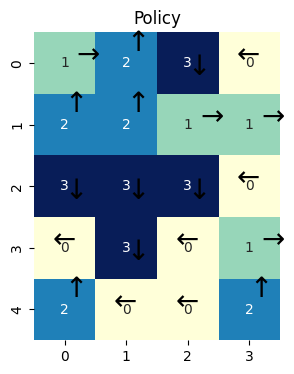

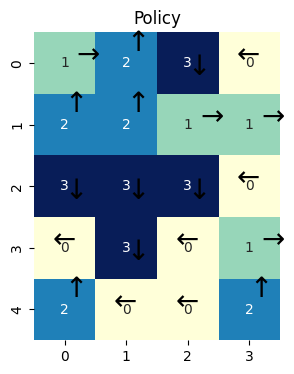

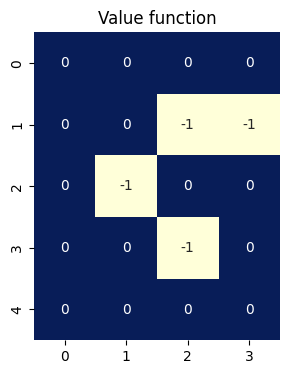

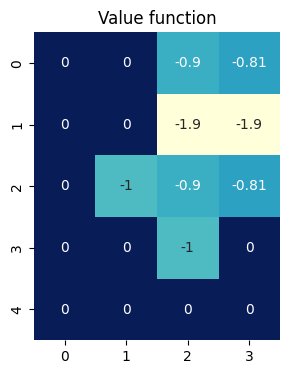

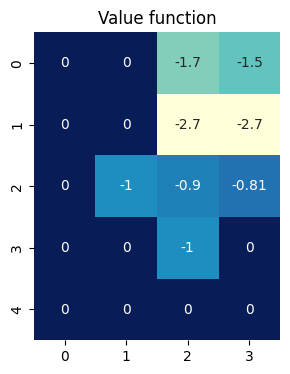

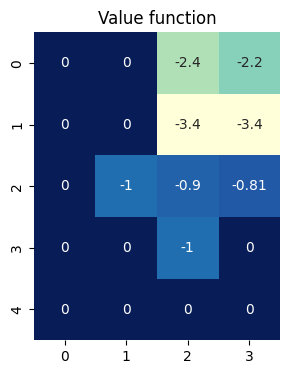

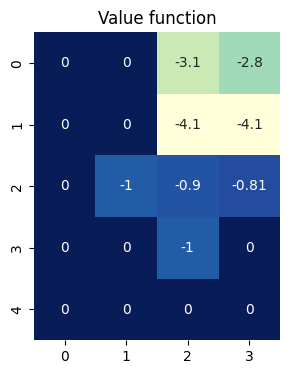

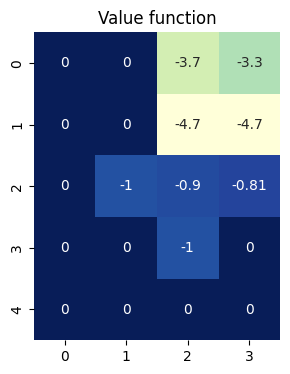

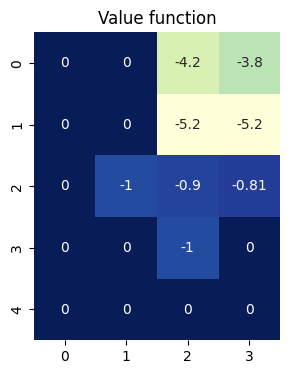

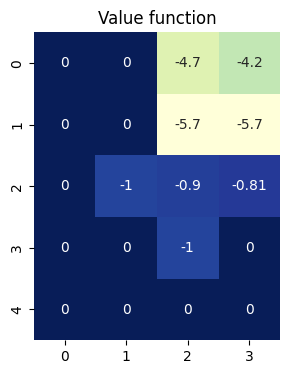

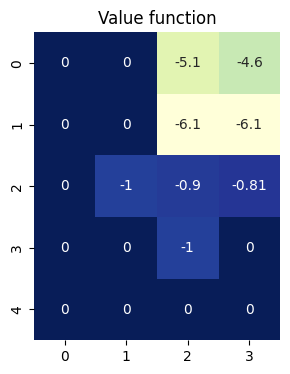

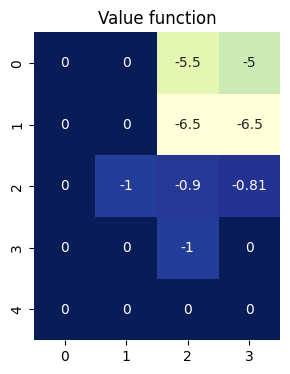

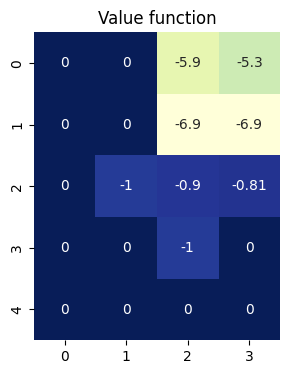

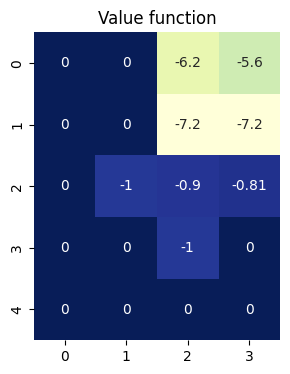

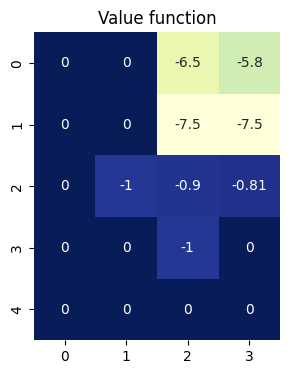

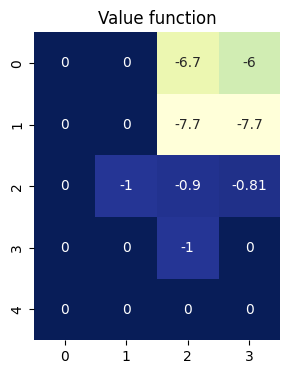

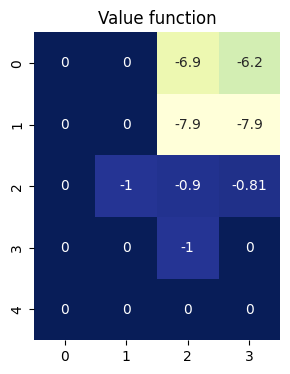

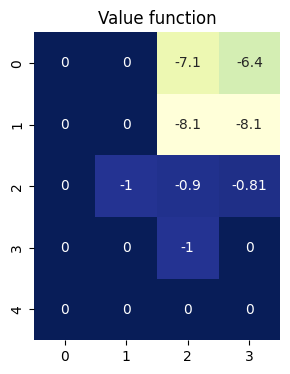

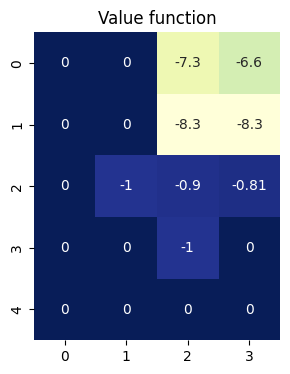

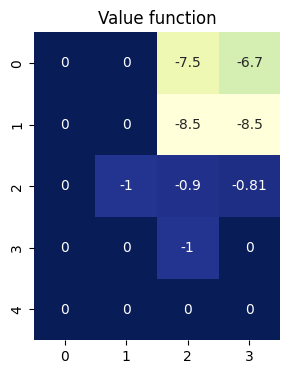

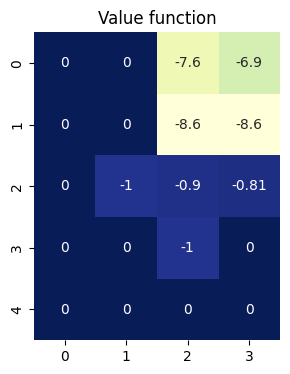

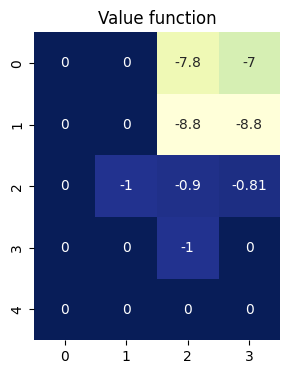

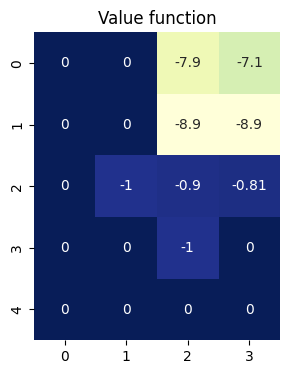

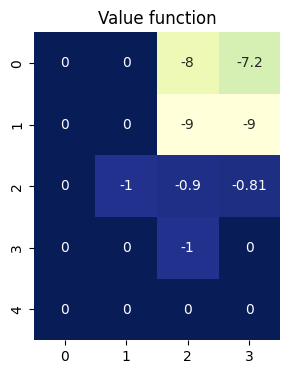

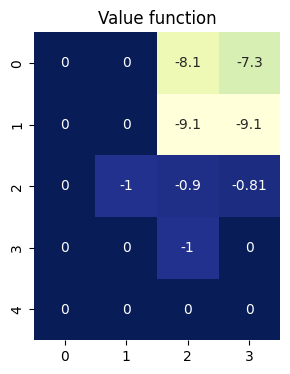

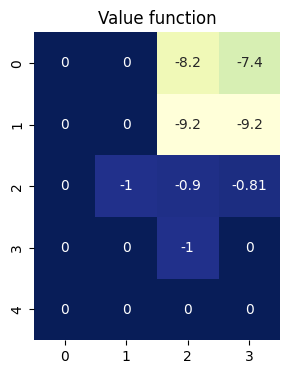

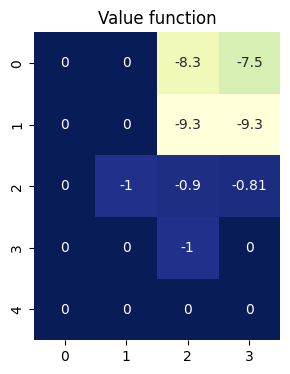

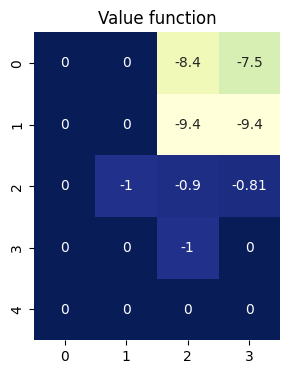

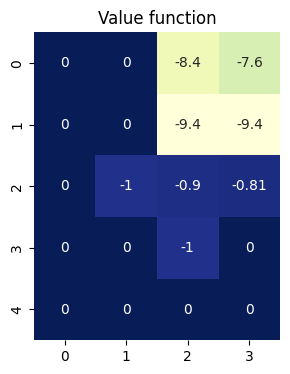

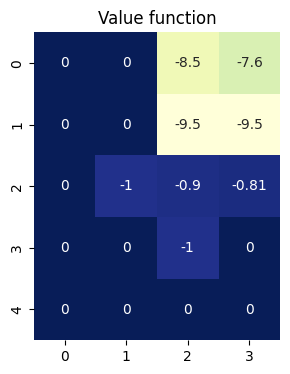

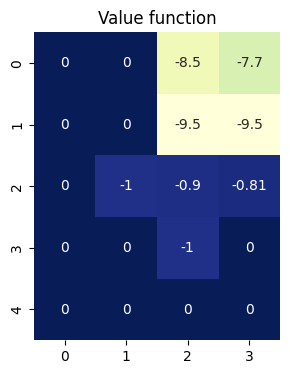

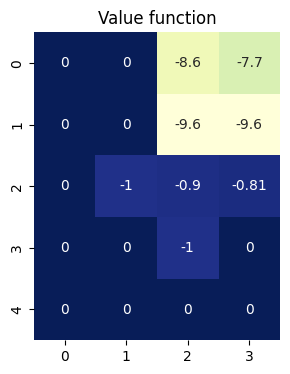

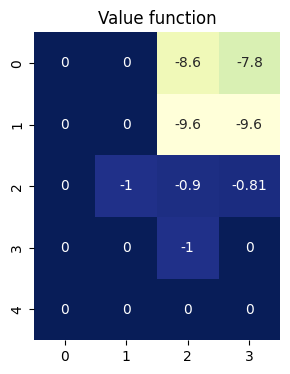

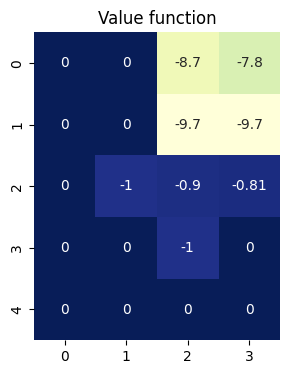

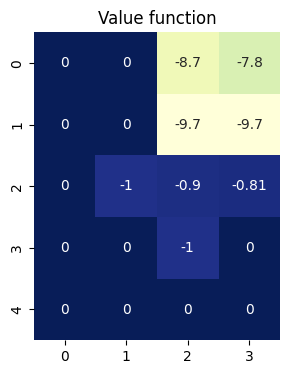

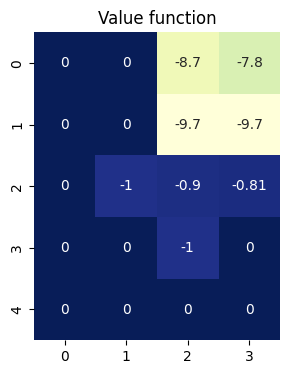

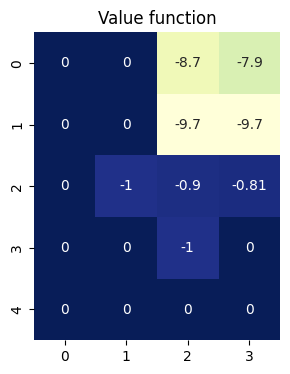

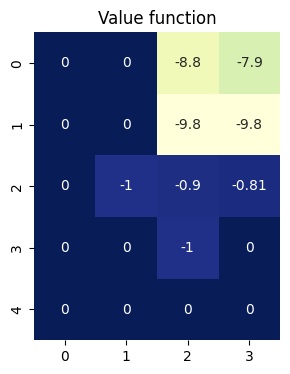

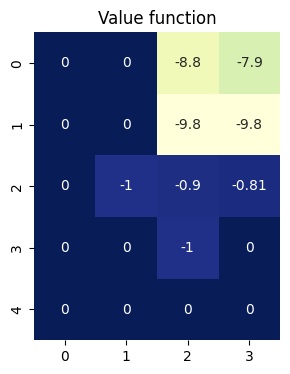

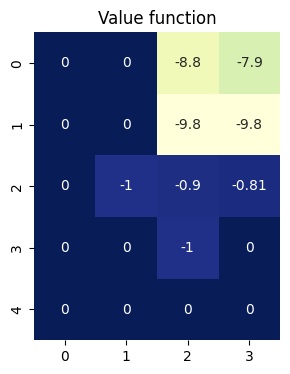

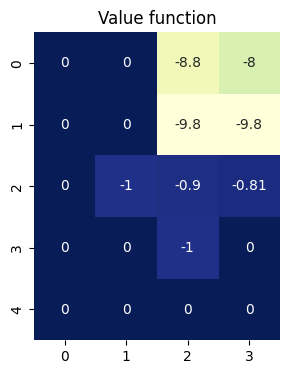

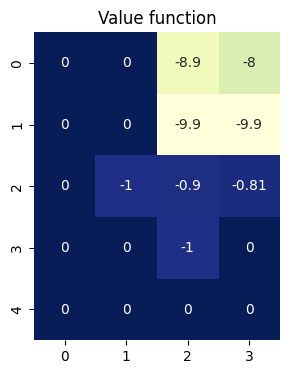

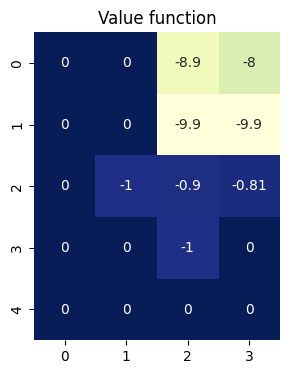

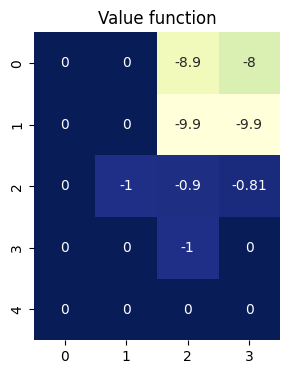

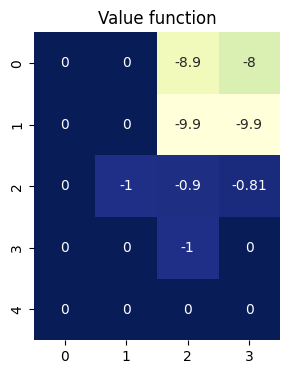

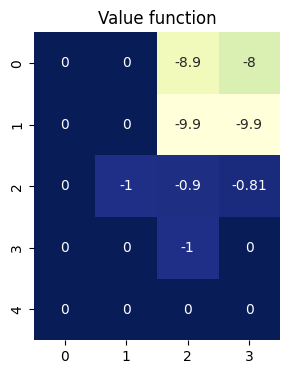

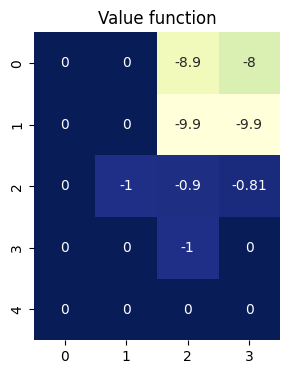

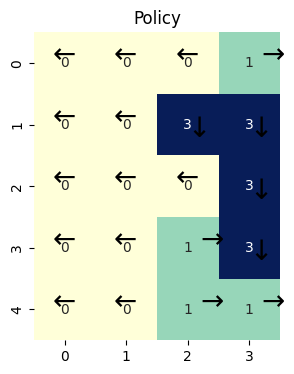

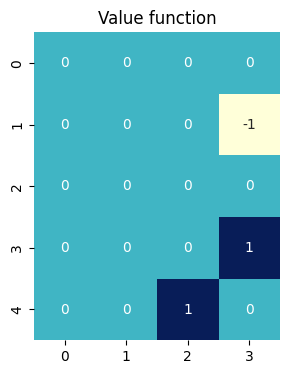

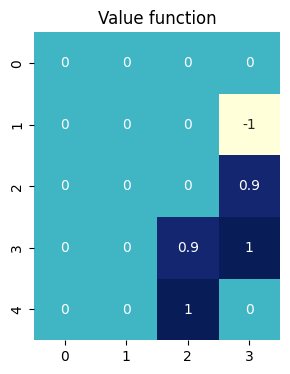

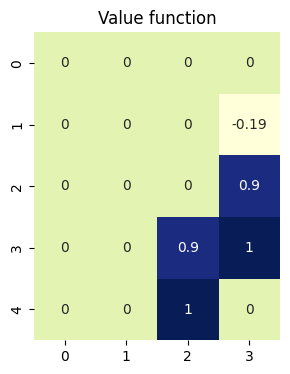

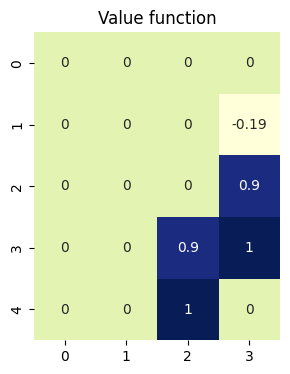

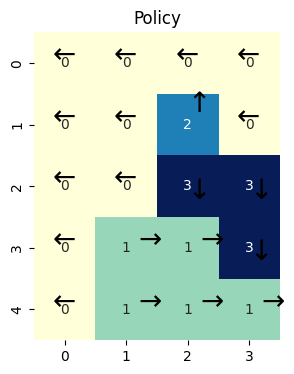

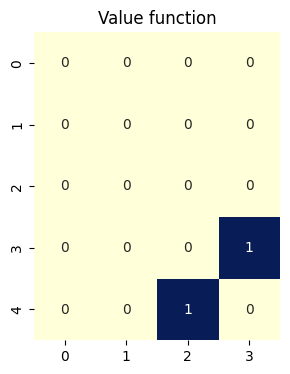

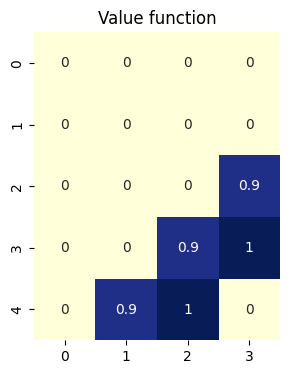

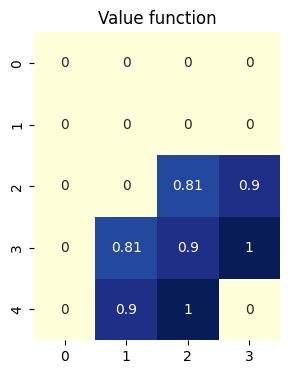

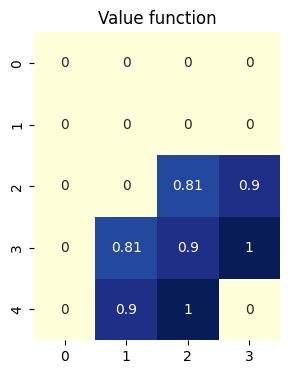

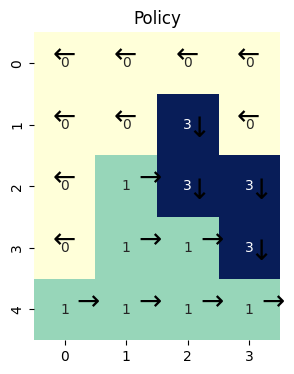

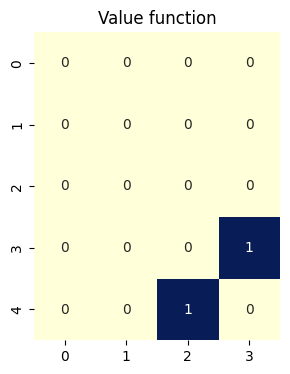

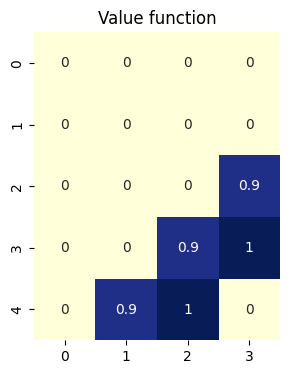

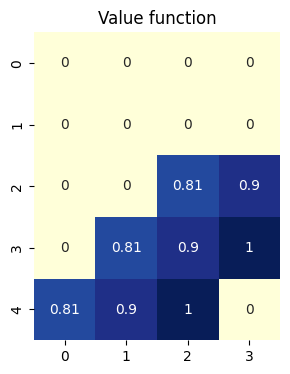

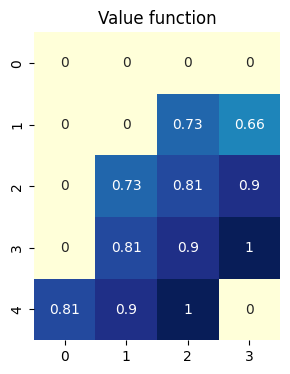

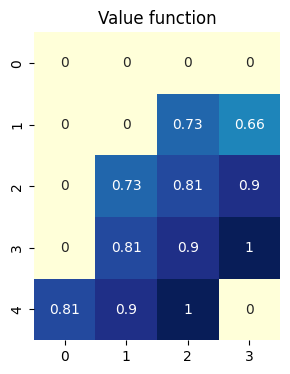

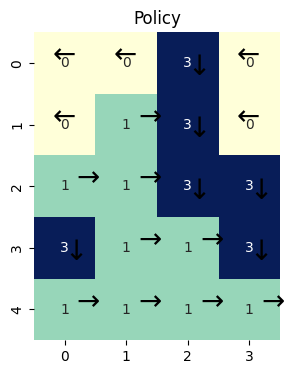

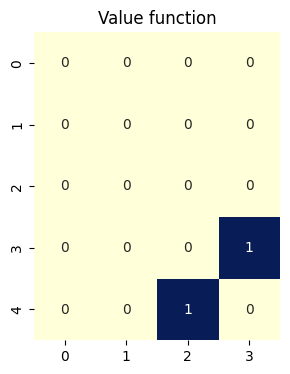

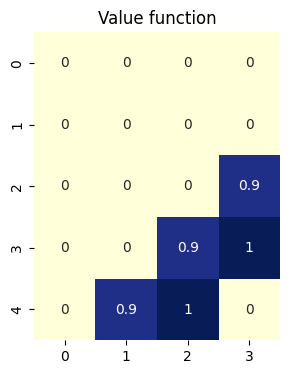

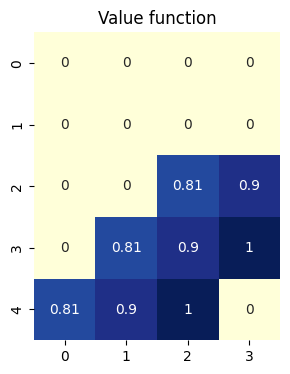

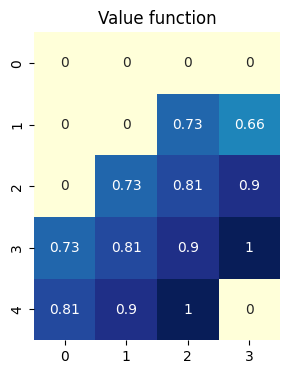

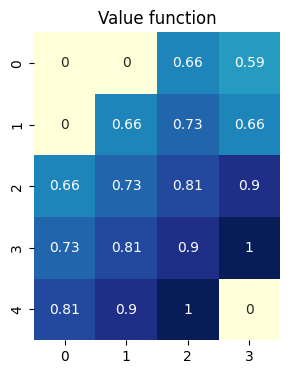

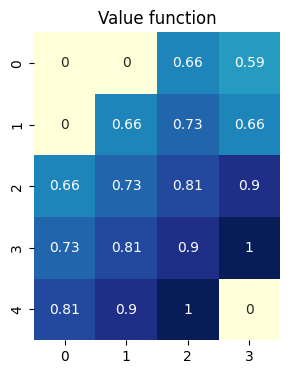

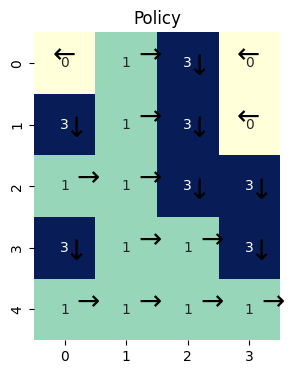

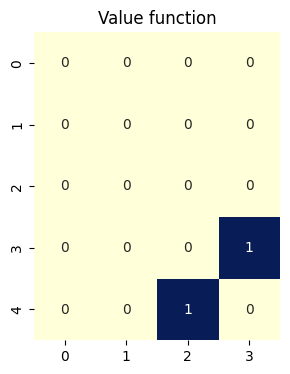

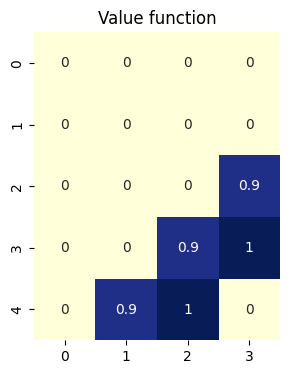

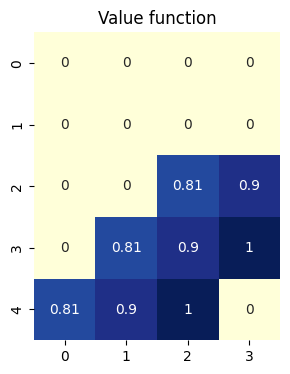

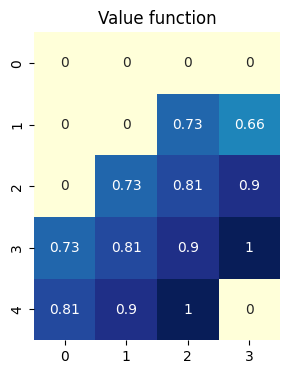

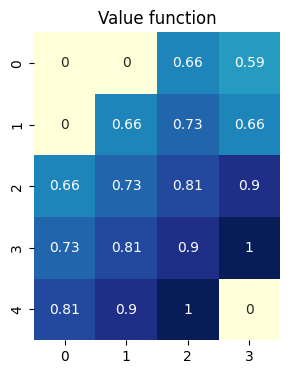

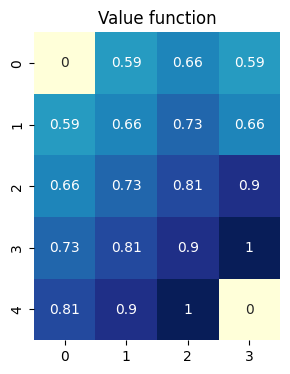

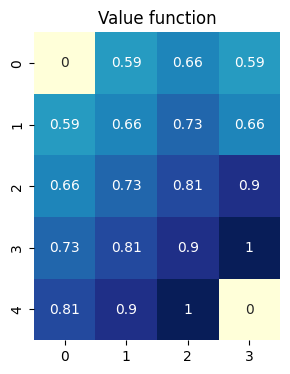

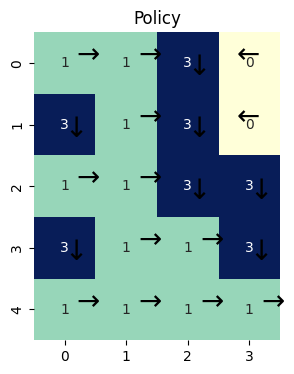

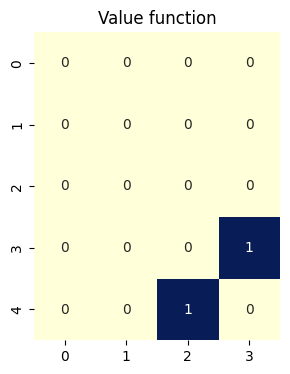

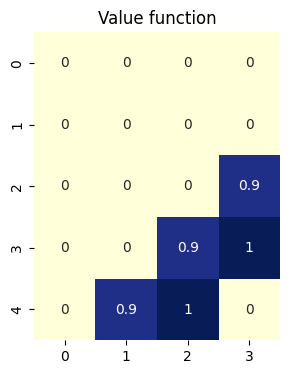

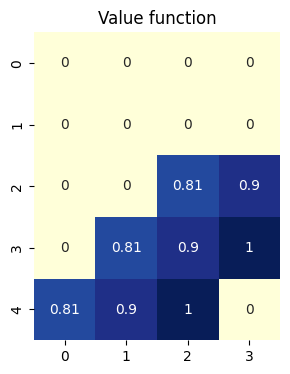

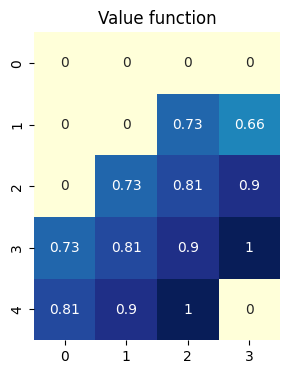

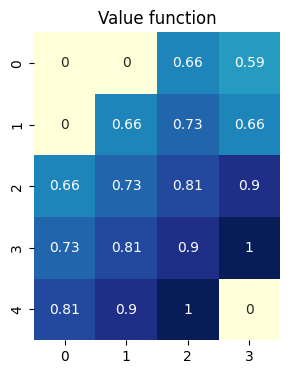

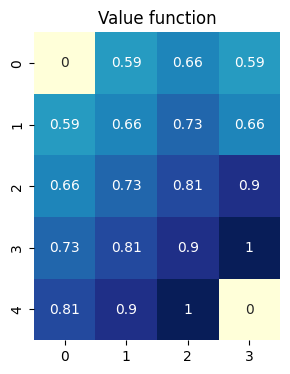

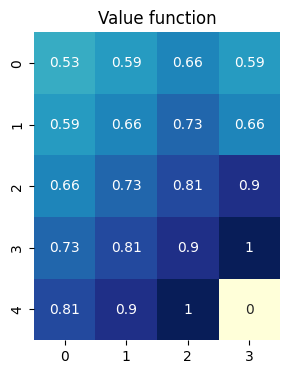

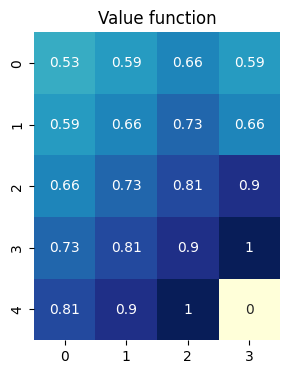

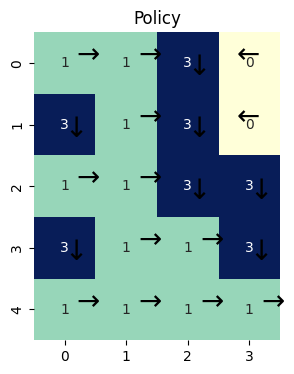

In [14]:
# main
env = FrozenLakeEnv()
policy, v = policy_iteration(env)
plot_policy(policy)

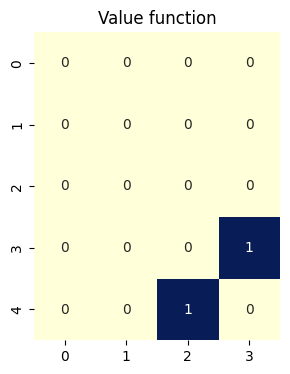

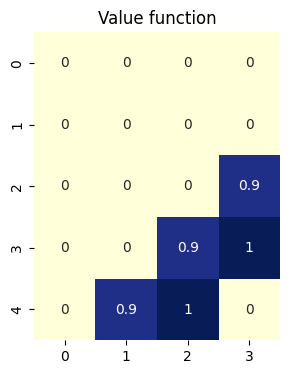

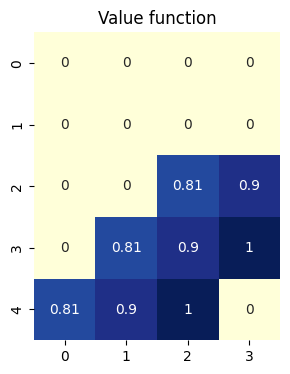

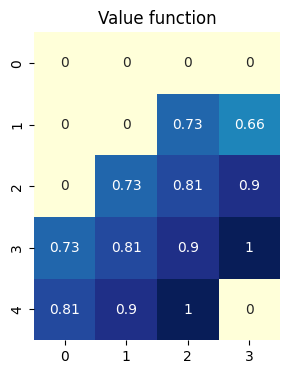

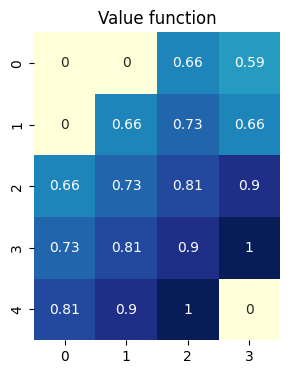

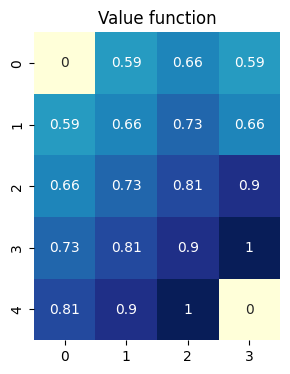

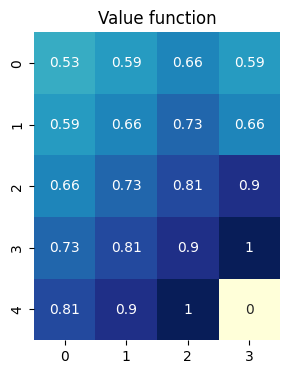

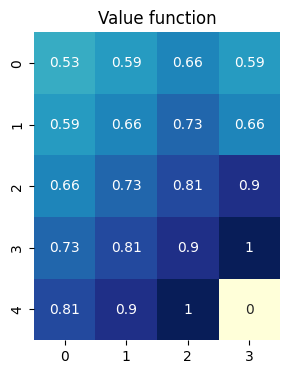

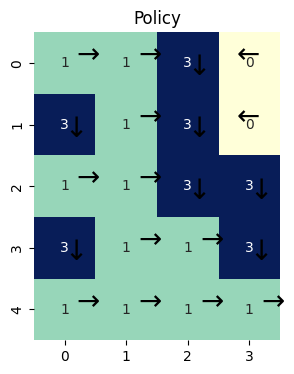

In [15]:
policy, v = value_iteration(env)
plot_policy(policy)